# K-Means: Evaluating cluster quality

Cluster quality metrics help select among alternative clustering results. This notebook illustrates several options, namely inertia and the silhouette scores.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from time import sleep

import numpy as np
from numpy.random import seed
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from IPython import display

In [3]:
seed(42)

In [4]:
sns.set_style('white')
cmap = ListedColormap(sns.xkcd_palette(['denim blue', 
                                        'medium green', 
                                        'pale red']))

In [5]:
cmap = ListedColormap(sns.color_palette('Paired', 10))

## 2D Cluster Demo

In [6]:
def sample_clusters(n_points=500,
                    n_dimensions=2,
                    n_clusters=5,
                    cluster_std=1):
    return make_blobs(n_samples=n_points,
                      n_features=n_dimensions,
                      centers=n_clusters,
                      cluster_std=cluster_std,
                      random_state=42)

## Evaluate Number of Clusters using Inertia

The k-Means objective function suggests we compare the evolution of the inertia or within-cluster variance. Initially, additional centroids decrease the inertia sharply because new clusters improve the overall fit. Once an appropriate number of clusters has been found (assuming it exists), new centroids reduce the within-cluster variance by much less as they tend to split natural groupings. 

Hence, when k-Means finds a good cluster representation of the data, the inertia tends to follow an elbow-shaped path similar to the explained variance ratio for PCA.

In [7]:
def inertia_plot_update(inertias, ax, delay=1):
    inertias.plot(color='k',
                  lw=1,
                  title='Inertia',
                  ax=ax,
                  xlim=(inertias.index[0], inertias.index[-1]),
                  ylim=(0, inertias.max()))
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)    
    display.display(plt.gcf())
    display.clear_output(wait=True)
    sleep(delay)

In [8]:
def plot_kmeans_result(data, labels, centroids,
                       assignments, ncluster, Z, ax):

    # plot data
    ax.scatter(*data.T, c=labels, s=20, cmap=cmap)

    # plot cluster centers
    ax.scatter(*centroids.T,
               marker='o',
               c='w',
               s=200,
               edgecolor='k',
               zorder=9)

    for i, c in enumerate(centroids):
        ax.scatter(*c,
                   marker=f'${i}$',
                   s=50,
                   edgecolor=['k'],
                   zorder=10)
        xy = pd.DataFrame(data[assignments == i],
                          columns=['x', 'y']).assign(cx=c[0],
                                                     cy=c[1])

        ax.plot(xy[['x', 'cx']].T.values,
                xy[['y', 'cy']].T.values,
                ls='--',
                color='k',
                lw=0.5)

    # plot voronoi
    ax.imshow(Z, interpolation='nearest',
              extent=(xx.min(), xx.max(), yy.min(), yy.max()),
              cmap=cmap,
              aspect='auto',
              origin='lower',
              alpha=.2)
    ax.set_title(f'Number of Clusters: {ncluster}')
    plt.tight_layout()

### Run Elbow Experiment

In [9]:
n_clusters, max_clusters = 4, 7
cluster_list = list(range(1, max_clusters + 1))
inertias = pd.Series(index=cluster_list)

In [10]:
data, labels = sample_clusters(n_clusters=n_clusters)
x, y = data.T

In [11]:
xx, yy = np.meshgrid(np.arange(x.min() - 1, x.max() + 1, .01), 
                     np.arange(y.min() - 1, y.max() + 1, .01))

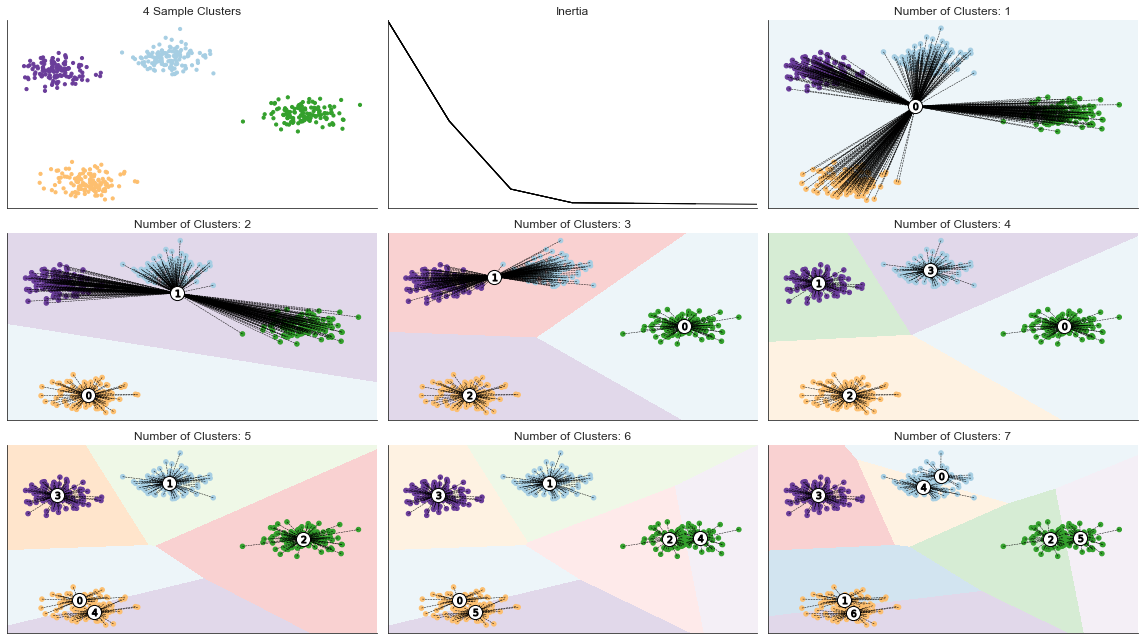

In [12]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(16, 9))
axes = np.array(axes).flatten()

# Plot Sample Data
axes[0].scatter(x, y, 
                c=labels, s=10, 
                cmap=cmap)
axes[0].set_title('{} Sample Clusters'.format(n_clusters))
for ax in axes:
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
sns.despine();


for c, n_clusters in enumerate(range(1, max_clusters + 1), 2):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(data)
    centroids, assignments, inertia = kmeans.cluster_centers_, kmeans.labels_, kmeans.inertia_
    inertias[n_clusters] = inertia
    inertia_plot_update(inertias, axes[1])
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plot_kmeans_result(data, labels, centroids, assignments,  n_clusters, Z, axes[c])
fig.tight_layout()

## Evaluating the Silhouette Score

The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) provides a more detailed picture of cluster quality. It answers the question: how far are the points in the nearest cluster relative to the points in the assigned cluster?
To this end, it compares the mean intra-cluster distance (a) to the mean distance of the nearest-cluster (b) and computes the following score s:

$$s=\frac{b−a}{\max(a,b)}\quad\in{[−1, 1]}$$

The score can vary between -1 and 1, but negative values are unlikely in practice because they imply that the majority of points are assigned to the wrong cluster. A useful visualization of the silhouette score compares the values for each data point to the global average because it highlights the coherence of each cluster relative to the global configuration. The rule of thumb is to avoid clusters with mean scores below the average for all samples.

The following figure shows an excerpt from the silhouette plot for three and four clusters, where the former highlights the poor fit of cluster 1 by sub-par contributions to the global silhouette score, whereas all of the four clusters have some values that exhibit above-average scores.

In [13]:
def plot_silhouette(values, y_lower, i, n_cluster, ax):
    cluster_size = values.shape[0]
    y_upper = y_lower + cluster_size

    color = plt.cm.viridis(i / n_cluster)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, values,
                facecolor=color, edgecolor=color, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * cluster_size, str(i))
    y_lower = y_upper + 10
    return y_lower

In [14]:
def format_silhouette_plot(ax):
    ax.set_title("Silhouette Plot")
    ax.set_xlabel("Silhouette Coefficient")
    ax.set_ylabel("Cluster Label")
    ax.axvline(x=silhouette_avg, 
               color='red', 
               linestyle='--', 
               lw=1)
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [15]:
def plot_final_assignments(x, y, centroids, 
                           assignments, n_cluster, ax):
    c = plt.cm.viridis(assignments / n_cluster)
    ax.scatter(x, y, marker='.', s=30, 
               lw=0, alpha=0.7, c=c, edgecolor='k')
    ax.scatter(*centroids.T, marker='o',  
               c='w', s=200, edgecolor='k')
    for i, c in enumerate(centroids):
        ax.scatter(*c, marker='${}$'.format(i), 
                   s=50, edgecolor='k')

    ax.set_title('{} Clusters'.format(n_cluster))

In [16]:
n_clusters = 4
max_clusters = 7
cluster_list = list(range(1, max_clusters + 1))
inertias = pd.Series(index=cluster_list)

In [17]:
data, labels = sample_clusters(n_clusters=n_clusters)
x, y = data.T

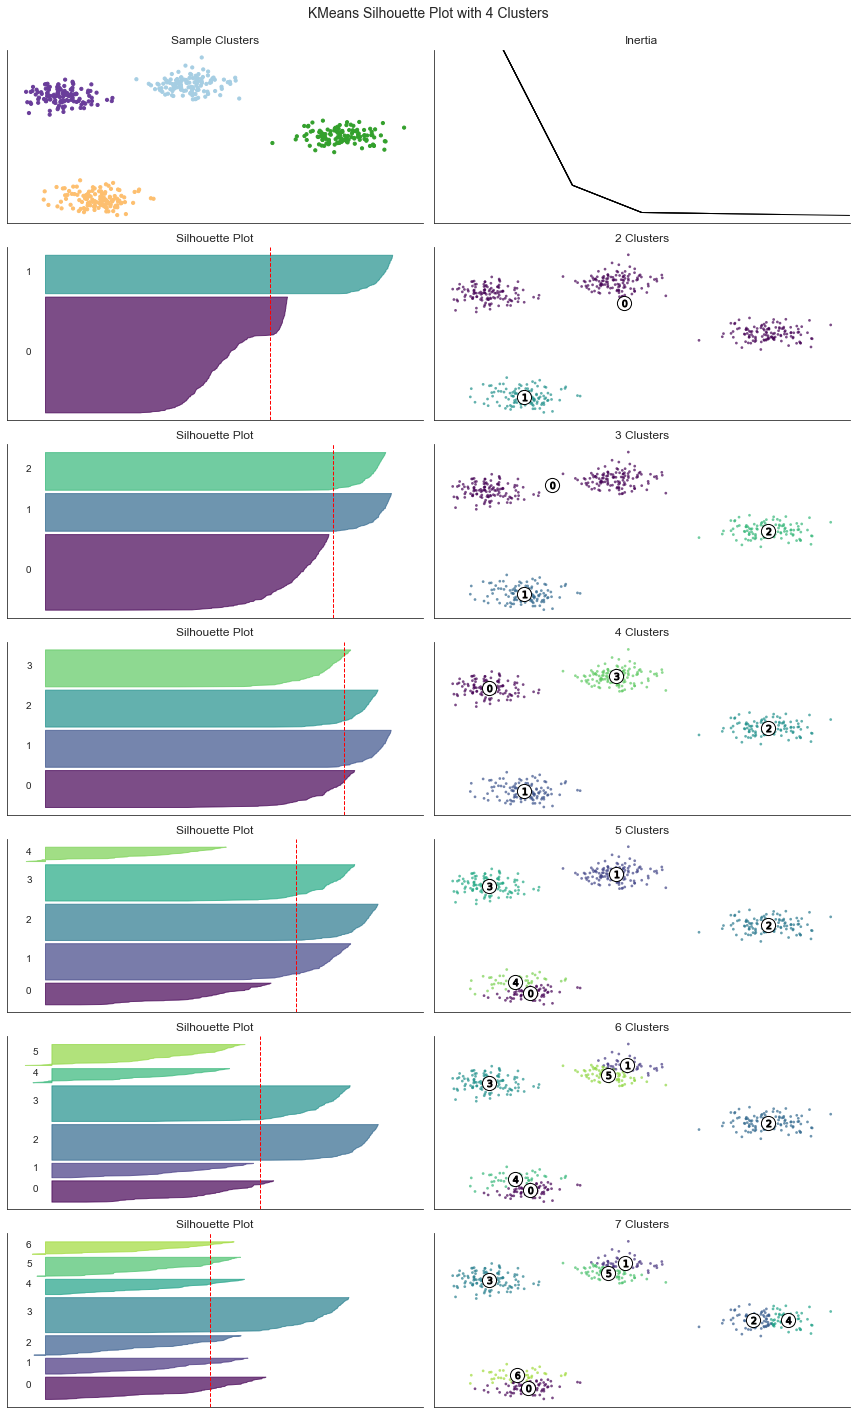

In [18]:
fig, axes = plt.subplots(ncols=2,
                         nrows=max_clusters,
                         figsize=(12, 20))

axes[0][0].scatter(x, y, c=labels, s=10, cmap=cmap)
axes[0][0].set_title('Sample Clusters')

for i in range(max_clusters):
    for j in [0, 1]:
        axes[i][j].axes.get_xaxis().set_visible(False)
        axes[i][j].axes.get_yaxis().set_visible(False)
sns.despine()

for row, n_cluster in enumerate(range(2, max_clusters + 1), 1):
    kmeans = KMeans(n_clusters=n_cluster,
                    random_state=42).fit(data)

    centroids, assignments, inertia = (kmeans.cluster_centers_,
                                       kmeans.labels_,
                                       kmeans.inertia_)
    inertias[n_cluster] = inertia
    inertia_plot_update(inertias, axes[0][1])

    silhouette_avg = silhouette_score(data, assignments)
    silhouette_values = silhouette_samples(data, assignments)
    silhouette_plot, cluster_plot = axes[row]

    y_lower = 10
    for i in range(n_cluster):
        y_lower = plot_silhouette(np.sort(silhouette_values[assignments == i]),
                                  y_lower,
                                  i,
                                  n_cluster,
                                  silhouette_plot)
    format_silhouette_plot(silhouette_plot)
    plot_final_assignments(x, y, centroids, assignments,
                           n_cluster, cluster_plot)
    fig.tight_layout()

fig.suptitle(f'KMeans Silhouette Plot with {n_clusters} Clusters',
             fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.95)

## Summary

In sum, given the usually unsupervised nature, it is necessary to vary the hyperparameters of the cluster algorithms and evaluate the different results. 

It is also important to calibrate the scale of the features, in particular when some should be given a higher weight and should thus be measured on a larger scale. Finally, to validate the robustness of the results, use subsets of data to identify whether particular patterns emerge consistently.